In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WAP     474 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


<Axes: >

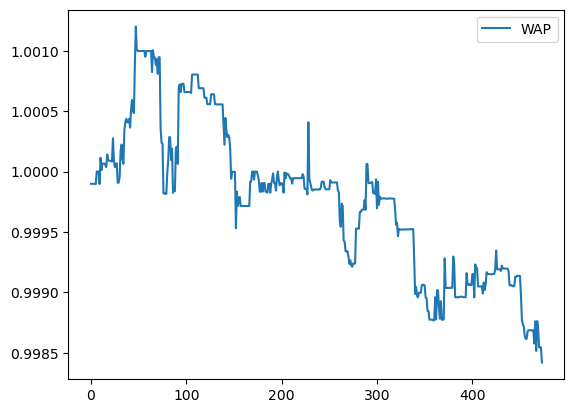

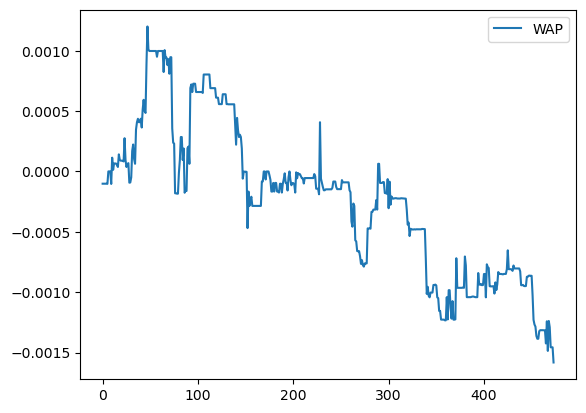

In [2]:
df = pd.read_csv("./individual_book_train/stock_10.csv")
df['WAP'] = (df['bid_price1']*df['ask_size1'] + df['ask_price1']*df['bid_size1']) /\
    (df['bid_size1'] + df['ask_size1'])
df_filtered = df[df['time_id'] == 11][['WAP']]
df_filtered = df_filtered.reset_index(drop=True)

df_filtered.info()
df_filtered.plot()
df_filtered_log = np.log(df_filtered)
df_filtered_log.plot()

define training and testing data

In [3]:
df_train = df_filtered_log.iloc[:400].copy()
df_test = df_filtered_log.iloc[400:].copy()

check for stationary

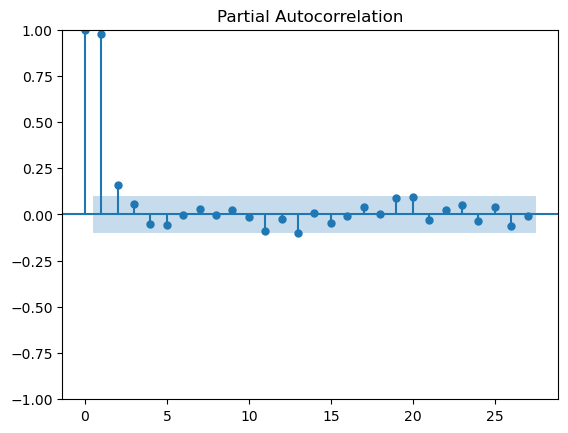

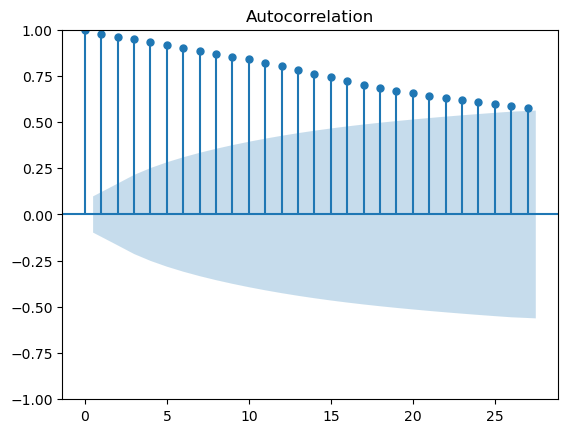

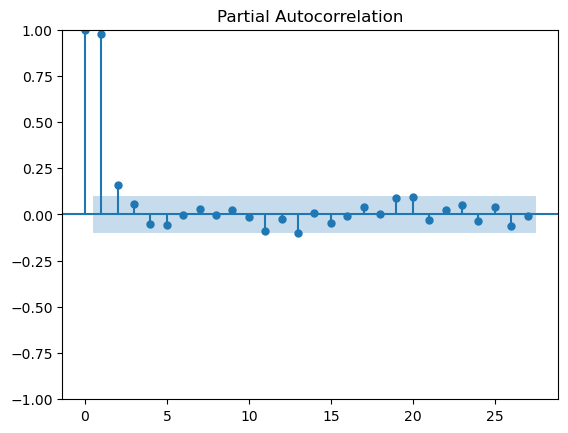

In [4]:
plot_acf(df_train)
plot_pacf(df_train)

ADF Test

In [5]:
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.6920219926037879


The large p-value means the test fails to rejct the null hypothesis, suggesting the time series is non-stationary

Use differencing to transform data to stationary.

<Axes: >

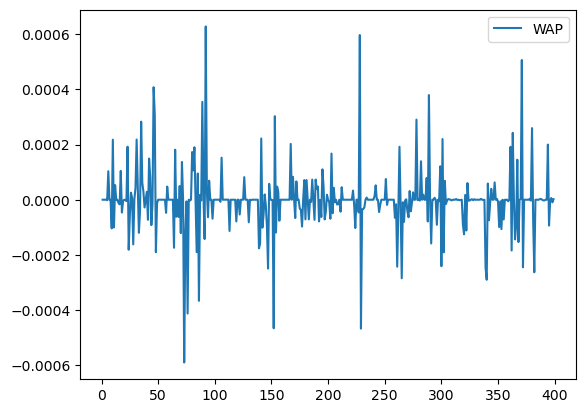

In [6]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

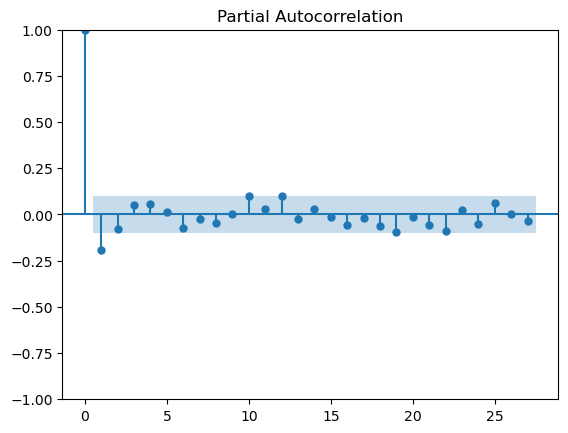

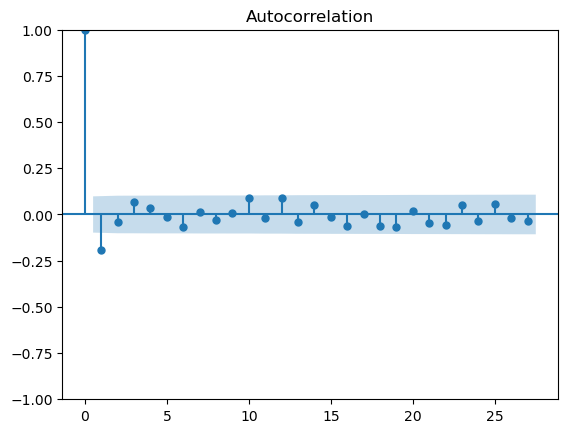

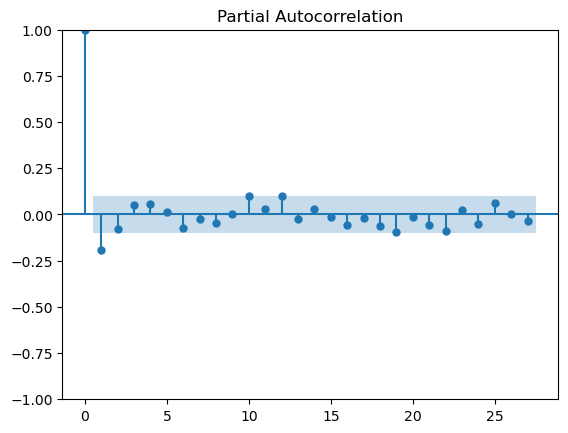

In [7]:
plot_acf(df_train_diff)
plot_pacf(df_train_diff)

In [8]:
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 1.852739915454148e-29


Therefore the paramater d = 1

Fit the ARIMA model

In [9]:
model = ARIMA(df_train, order = (2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    WAP   No. Observations:                  400
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3068.110
Date:                Sun, 14 Apr 2024   AIC                          -6130.221
Time:                        14:53:51   BIC                          -6118.254
Sample:                             0   HQIC                         -6125.481
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2060   4.99e-19  -4.13e+17      0.000      -0.206      -0.206
ar.L2         -0.0780   8.88e-19  -8.79e+16      0.000      -0.078      -0.078
sigma2      1.205e-08   3.66e-10     32.910      0.0

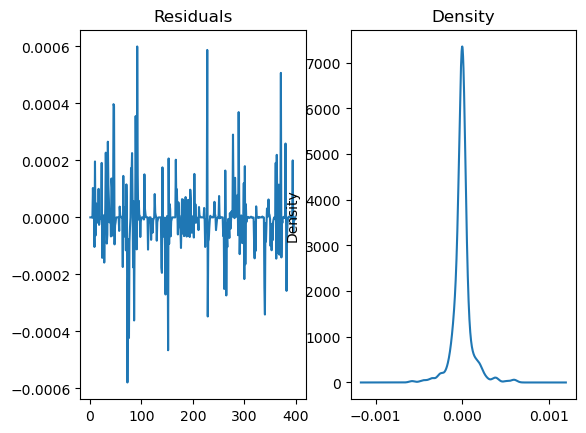

In [10]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

Plot for prediction.

<Axes: >

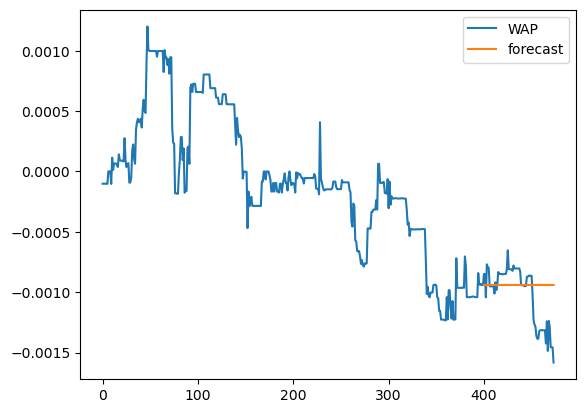

In [11]:
forecast_test = model_fit.forecast(len(df_test))
df_filtered_log['forecast'] = [None]*len(df_train) + list(forecast_test)
df_filtered_log.plot()

Auto-fit the ARIMA model

In [12]:
auto_arima = pm.auto_arima(df_train, stepwise = False, seasonal = False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3067.708
Date:                Sun, 14 Apr 2024   AIC                          -6129.415
Time:                        14:54:02   BIC                          -6117.448
Sample:                             0   HQIC                         -6124.676
                                - 400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -2.94e-06   4.51e-06     -0.652      0.515   -1.18e-05     5.9e-06
ma.L1         -0.2027   1.62e-11  -1.25e+10      0.000      -0.203      -0.203
sigma2      1.233e-08   3.84e-10     32.120      0.000    1.16e-08    1.31e-08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1383.10
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+24. Standard errors may be unstable.
"""

Resulting a different ARIMA model ARMIA(0,1,1) where the graph above shows the prediction for ARIMA(2,1,0).

In [13]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
mae210 = mean_absolute_error(df_test, forecast_test)
mape210 = mean_absolute_percentage_error(df_test, forecast_test)
rmse210 = np.sqrt(mean_squared_error(df_test, forecast_test))

mae011 = mean_absolute_error(df_test, forecast_test_auto)
mape011 = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse011 = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'Mean Absolute Error - manual: {mae210}')
print(f'Mean Absolute Error - auto: {mae011}')
print(f'Mean Absolute Percentage Error - manual: {mape210}')
print(f'Mean Absolute Percentage Error - auto: {mape011}')
print(f'Mean Aquared Error - manual: {rmse210}')
print(f'Mean Aquared Error - auto: {rmse011}')

Mean Absolute Error - manual: 0.0001832446925958932
Mean Absolute Error - auto: 0.0001758339825473156
Mean Absolute Percentage Error - manual: 0.16353096828563354
Mean Absolute Percentage Error - auto: 0.17949107462262068
Mean Aquared Error - manual: 0.00024605342940609644
Mean Aquared Error - auto: 0.00019577493388912514
